
# <!-- TITLE --> [IMDB2] - Sentiment analysis with text embedding
<!-- DESC --> A very classical example of word embedding with a dataset from Internet Movie Database (IMDB)
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Understand the management of **textual data** and **sentiment analysis**

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Import and init
### 1.1 - Python stuff

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload


run_dir = './run/IMDB2'
datasets_dir = 'fidle-datasets'

### 1.2 - Parameters
The words in the vocabulary are classified from the most frequent to the rarest.  
`vocab_size` is the number of words we will remember in our vocabulary (the other words will be considered as unknown).  
`hide_most_frequently` is the number of ignored words, among the most common ones  
`review_len` is the review length  
`dense_vector_size` is the size of the generated dense vectors  
`output_dir` is where we will go to save our dictionaries. (./data is a good choice)\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [4]:
vocab_size           = 10000
hide_most_frequently = 0

review_len           = 256
dense_vector_size    = 16

epochs               = 30
batch_size           = 512

output_dir           = './data'
fit_verbosity        = 1

## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

For more details about the management of this dataset, see notebook [IMDB1](01-One-hot-encoding.ipynb)

### 2.2 - Get dataset

In [5]:
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=vocab_size, skip_top=hide_most_frequently, seed= 42,)

y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

# ---- About
#

print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)


### 2.2 - Load dictionary
Not essential, but nice if you want to take a closer look at our reviews ;-)

In [6]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#      Shift the dictionary from +3
#      Add <pad>, <start> and <unknown> tags
#      Create a reverse dictionary : {index:word}
#
word_index = imdb.get_word_index()
word_index = {w:(i+3) for w,i in word_index.items()}
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )
index_word = {index:word for word,index in word_index.items()} 

# ---- A nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [8]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

print('After padding :')
print(x_train[12])

After padding :
[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 

**Save dataset and dictionary (For future use but not mandatory)**

In [9]:
# ---- Write dataset in a h5 file, could be usefull
#
def mkdir(path):
    os.makedirs(path, mode=0o750, exist_ok=True)
    
mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [10]:
def get_model(vocab_size=10000, dense_vector_size=32, review_len=256):
    
    model = keras.Sequential()
    model.add(keras.layers.Input( shape=(review_len,) ))
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(dense_vector_size, activation='relu'))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [11]:
model = get_model(vocab_size, dense_vector_size, review_len)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [12]:
os.makedirs(f'{run_dir}/models',   mode=0o750, exist_ok=True)
save_dir = f'{run_dir}/models/best_model.h5'
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it

In [13]:
%%time

history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/30
49/49 [==============================] - 4s 25ms/step - loss: 0.6911 - accuracy: 0.5527 - val_loss: 0.6869 - val_accuracy: 0.6230
Epoch 2/30
49/49 [==============================] - 1s 21ms/step - loss: 0.6761 - accuracy: 0.6581 - val_loss: 0.6621 - val_accuracy: 0.7480
Epoch 3/30
49/49 [==============================] - 1s 21ms/step - loss: 0.6346 - accuracy: 0.7669 - val_loss: 0.6094 - val_accuracy: 0.7867
Epoch 4/30
49/49 [==============================] - 1s 20ms/step - loss: 0.5655 - accuracy: 0.8080 - val_loss: 0.5368 - val_accuracy: 0.8121
Epoch 5/30
49/49 [==============================] - 1s 21ms/step - loss: 0.4854 - accuracy: 0.8400 - val_loss: 0.4675 - val_accuracy: 0.8346
Epoch 6/30
49/49 [==============================] - 1s 20ms/step - loss: 0.4148 - accuracy: 0.8614 - val_loss: 0.4130 - val_accuracy: 0.8488
Epoch 7/30
49/49 [==============================] - 1s 21ms/step - loss: 0.3630 - accuracy: 0.8755 - val_loss: 0.3748 - val_accuracy: 0.8567
Epoch 8/30
49

## Step 6 - Evaluate
### 6.1 - Training history

In [15]:
import pandas as pd
df=pd.DataFrame(data=history.history)
display(df)

,loss,accuracy,val_loss,val_accuracy
0,0.691066,0.55272,0.686886,0.62296
1,0.676073,0.65812,0.662095,0.74804
2,0.634646,0.76692,0.609448,0.78672
3,0.565468,0.80804,0.536775,0.81212
4,0.485378,0.84004,0.467541,0.83456
5,0.414849,0.86144,0.413011,0.84876
6,0.363001,0.87548,0.374828,0.85668
7,0.324447,0.88676,0.350326,0.86376
8,0.296184,0.89356,0.331209,0.86776
9,0.273863,0.90140,0.317720,0.87156


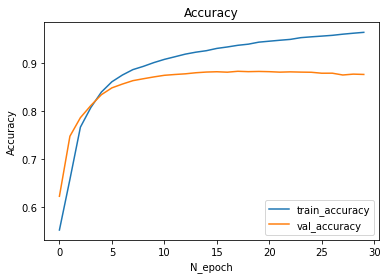

In [16]:
plt.figure()
plt.plot(df['accuracy'],label='train_accuracy')
plt.plot(df['val_accuracy'],label='val_accuracy')
plt.title("Accuracy")
plt.xlabel('N_epoch')
plt.ylabel('Accuracy')
plt.legend()

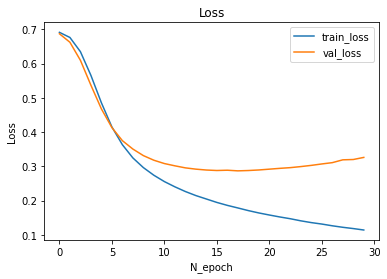

In [17]:
plt.figure()
plt.plot(df['loss'],label='train_loss')
plt.plot(df['val_loss'],label='val_loss')
plt.title("Loss")
plt.xlabel('N_epoch')
plt.ylabel('Loss')
plt.legend()


### 6.2 - Reload and evaluate best model

In [22]:
from IPython.display import Markdown

def plot_donut(values, labels, colors=["lightsteelblue","coral"], figsize=(6,6), title=None):
    """
    Draw a donut
    args:
        values   : list of values
        labels   : list of labels
        colors   : list of color (["lightsteelblue","coral"])
        figsize  : size of figure ( (6,6) )
    return:
        nothing
    """
    # ---- Title or not
    if title != None :  display(Markdown(title))
    # ---- Donut
    plt.figure(figsize=figsize)
    # ---- Draw a pie  chart..
    plt.pie(values, labels=labels, 
            colors = colors, autopct='%1.1f%%', startangle=70, pctdistance=0.85,
            textprops={'fontsize': 18},
            wedgeprops={"edgecolor":"w",'linewidth': 5, 'linestyle': 'solid', 'antialiased': True})
    # ---- ..with a white circle
    circle = plt.Circle((0,0),0.70,fc='white')
    ax = plt.gca()
    ax.add_artist(circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.tight_layout()
    plt.show()

x_test / loss      : 0.2867
x_test / accuracy  : 0.8833


#### Accuracy donut is :

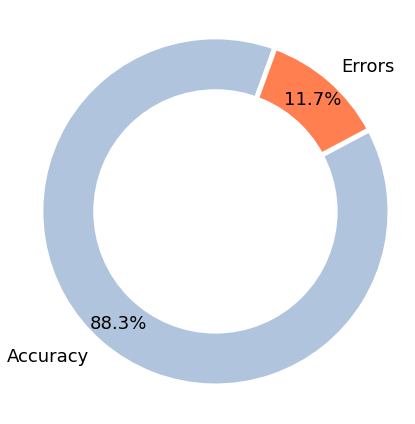

confusion_matrix:


<AxesSubplot:>

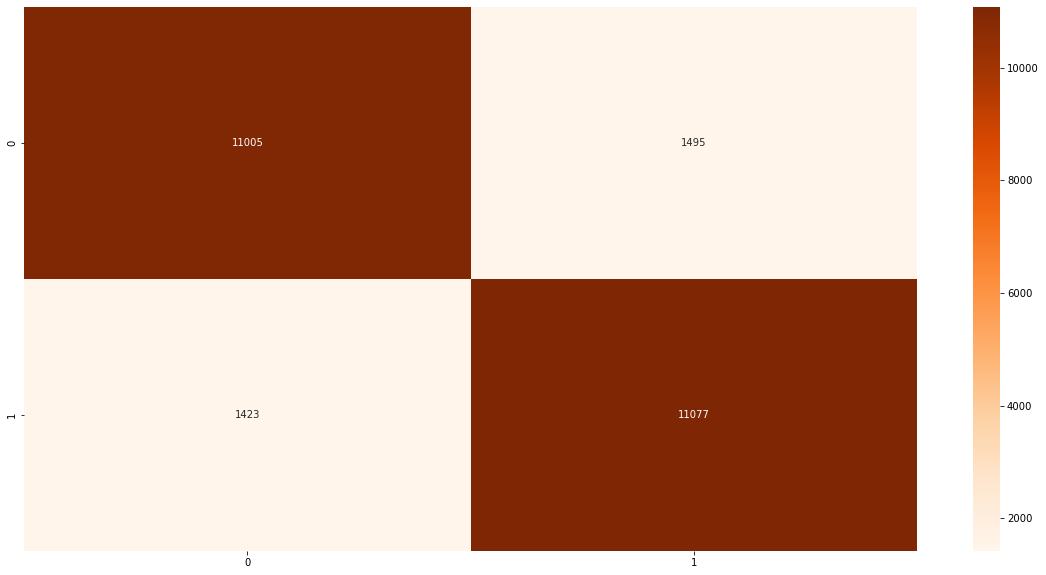

In [25]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :")

# ---- Confusion matrix

from sklearn.metrics import confusion_matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

print('confusion_matrix:')

import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='1', cmap='Oranges')
